# Assignment 5

License
Copyright 2021 - 2025 Parth Kasat(parth.kasat@gwu.edu) and Zixiao He(zixiao.he@gwu.edu)

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

#### Imports and inits

In [1]:
!pip install interpret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 24.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 852.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 68.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 71.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 83.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.9/778.9 kB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 10.3 MB/s eta 0:00:00
   ━━━━━━

In [2]:
from interpret.glassbox import ExplainableBoostingClassifier      # interpret ebm class
from interpret.perf import ROC                                    # ROC measure for ebm
import numpy as np                                                # for basic array manipulation
import pandas as pd                                               # for dataframe manipulation
import time                                                       # for timers

# plotting functionality
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D # necessary for custom legends

# display plots in notebook
%matplotlib inline

# set numpy random seed for better reproducibility
SEED = 12345
np.random.seed(SEED)

# set number of threads
NTHREAD = 4

#### Import data

In [3]:
data = pd.read_csv('/content/hmda_train_preprocessed.csv')

#### Assign basic modeling roles

In [4]:
y_name = 'high_priced'

## Fit interpretable model

#### Split data into train and validation partitions

In [5]:
np.random.seed(SEED) # preserve exact reproducibility for this cell

split_ratio = 0.7 # 70%/30% train/test split

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
valid = data[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

# benchmark - Train data rows = 112253, columns = 23
# benchmark - Validation data rows = 48085, columns = 23

Train data rows = 112253, columns = 23
Validation data rows = 48085, columns = 23


### Explainable Boosting Machine

#### Retrain most accurate model above 0.8 AIR to debug

In [6]:
from sklearn.utils.class_weight import compute_sample_weight
# Compute weights for balanced learning
weights = compute_sample_weight(class_weight='balanced', y=train[y_name])

rem_params = {'max_bins': 256,
 'max_interaction_bins': 32,
 'interactions': 15,
 'outer_bags': 4,
 'inner_bags': 0,
 'learning_rate': 0.001,
 'validation_size': 0.1,
 'min_samples_leaf': 1,
 'max_leaves': 5,
#  {'max_bins': 512,
#               'max_interaction_bins': 16,
#               'interactions': 10,
#               'outer_bags': 4,
#               'inner_bags': 0,
#               'learning_rate': 0.001,
#               'validation_size': 0.25,
#               'min_samples_leaf': 5,
#               'max_leaves': 5,
              'early_stopping_rounds': 100.0,
              'n_jobs': NTHREAD,
              'random_state': SEED}

rem_x_names = ['property_value_std',
               'no_intro_rate_period_std',
               'loan_amount_std',
               'income_std',
               'conforming',
               'intro_rate_period_std',
               'debt_to_income_ratio_std',
               'term_360']

# Safely cap features to reduce outlier influence (1st and 99th percentiles)
for col in rem_x_names:
    lower = train[col].quantile(0.01)
    upper = train[col].quantile(0.99)
    train.loc[:, col] = train[col].clip(lower, upper)
    valid.loc[:, col] = valid[col].clip(lower, upper)


# reset some parameters to integers
rem_params['random_state'] = int(rem_params['random_state'])
rem_params['n_jobs'] = int(rem_params['n_jobs'])
rem_params['early_stopping_rounds'] = int(rem_params['early_stopping_rounds'])

# retrain
rem_ebm = ExplainableBoostingClassifier(**rem_params)
rem_ebm.fit(train[rem_x_names], train[y_name],sample_weight=weights)
rem_ebm_perf = ROC(rem_ebm.predict_proba).explain_perf(valid[rem_x_names], valid[y_name])
rem_auc = rem_ebm_perf._internal_obj['overall']['auc']
print('Remediated EBM retrained with AUC: %.4f.' % rem_auc)

Remediated EBM retrained with AUC: 0.8097.


## Sensitivity Analysis: Stress Testing

#### Simulate recession conditions in validation data

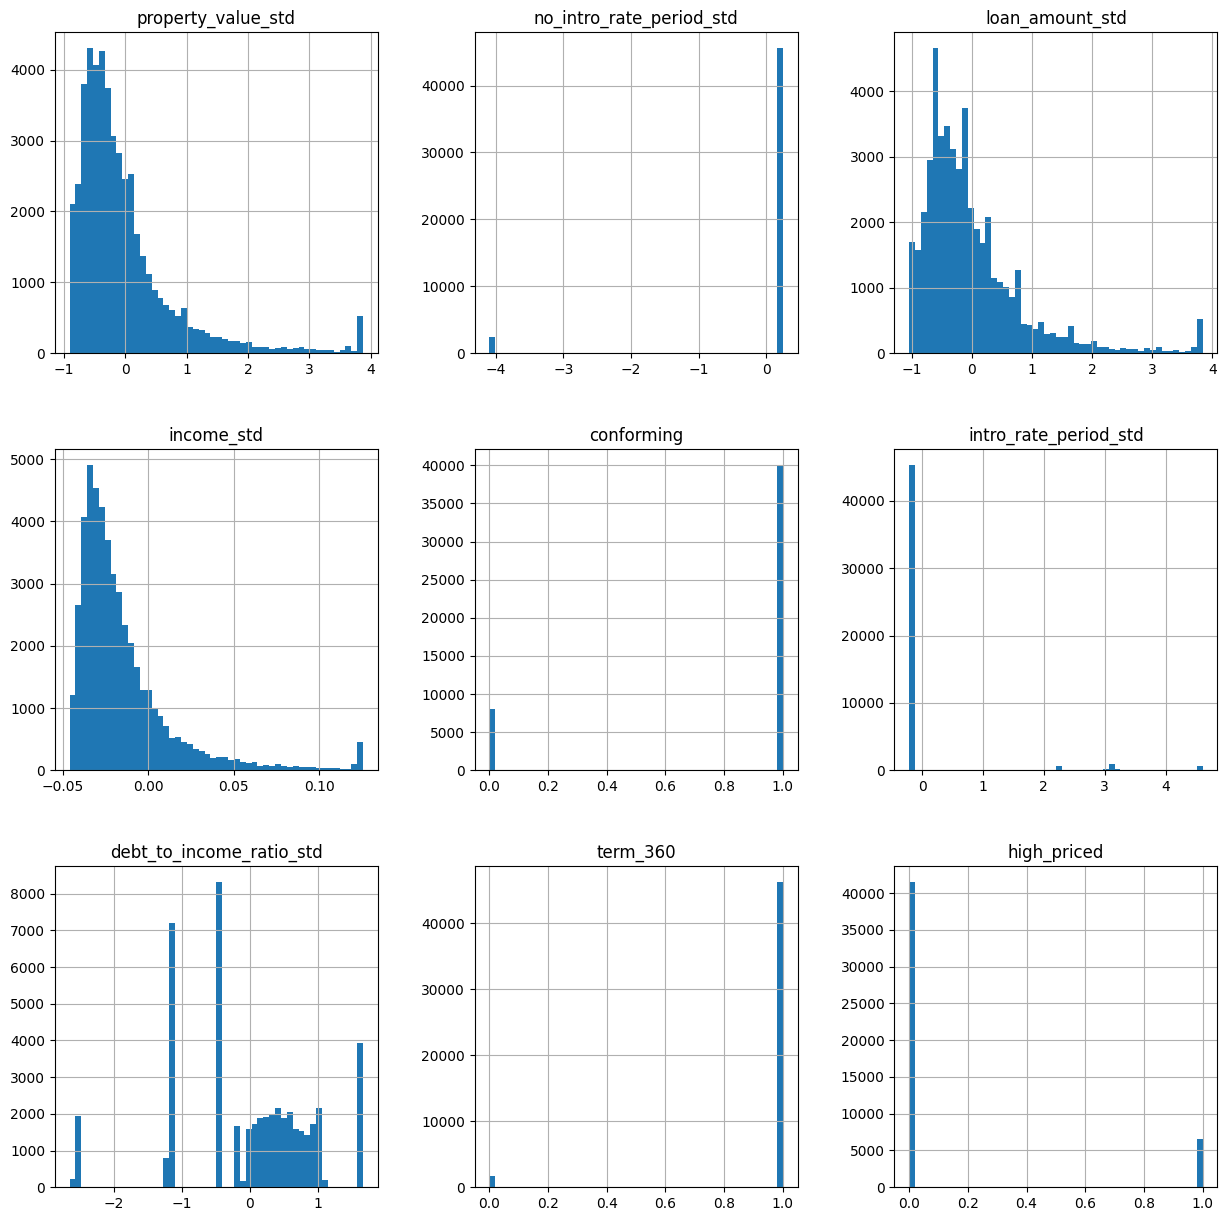

In [7]:
np.random.seed(SEED) # set seed for this cell

rec_valid = valid.copy(deep=True) # deep copy of validation data

# use severity variable to control how many customers are affected
severity = 0.1
affected = np.random.rand(len(rec_valid)) < severity

# decrease property values by 5%
rec_valid.loc[affected, 'property_value_std'] = rec_valid.loc[affected, 'property_value_std'] * 0.95

# less intro rates
rec_valid.loc[affected, 'no_intro_rate_period_std'] = 0.2443944

# lower loan amounts by 5%
rec_valid.loc[affected, 'loan_amount_std'] = rec_valid.loc[affected, 'loan_amount_std'] * 0.95

# lower income by 5%
rec_valid.loc[affected, 'income_std'] = rec_valid.loc[affected, 'income_std'] * 0.95

# less conforming loans
rec_valid.loc[affected, 'conforming'] = 0

# shorter intro rate periods
rec_valid.loc[affected, 'intro_rate_period_std'] = rec_valid.loc[affected, 'intro_rate_period_std'] * 0.95

# 5% higher debt-to-income ratios
rec_valid.loc[affected, 'debt_to_income_ratio_std'] = rec_valid.loc[affected, 'debt_to_income_ratio_std'] * 1.05

# more long loans
rec_valid.loc[affected, 'term_360'] = 1

# update target
rec_valid.loc[affected, y_name] = np.random.choice(2, len(rec_valid.loc[affected, y_name]))

# visualize results
_ = rec_valid[rem_x_names + [y_name]].hist(bins=50, figsize=(15, 15))

#### Find AUC for best model in simulated recession conditions

In [8]:
rec_rem_ebm_perf = ROC(rem_ebm.predict_proba).explain_perf(rec_valid[rem_x_names], rec_valid[y_name])
rec_rem_auc = rec_rem_ebm_perf._internal_obj['overall']['auc']
print('Remediated EBM retrained with AUC: %.4f.' % rec_rem_auc)

Remediated EBM retrained with AUC: 0.6625.


Note the major drop in performance for recession conditions, which is normal for all models and usually worse for complex ML models. It's not unlikely that the more constrained monotonic GBM or penalized GLM could perform better in these conditions.

Also, this tells us we need to monitor this model carefully, because when recession conditions begin, this model will fail quickly.

## Residual Analysis

#### Calculate predictions and logloss residuals for all data

In [9]:
# shortcut names
yhat_name = 'phat'
r_name = 'r'

# calculate predictions
rem_ebm_phat = pd.DataFrame(rem_ebm.predict_proba(data[rem_x_names])[:, 1], columns=['phat'])
rem_ebm_phat = pd.concat([data.reset_index(drop=True), rem_ebm_phat], axis=1)

# calculate logloss residuals
rem_ebm_phat[r_name] = -rem_ebm_phat[y_name]*np.log(rem_ebm_phat[yhat_name]) -\
                       (1 - rem_ebm_phat[y_name])*np.log(1 - rem_ebm_phat[yhat_name])

#### Plot residuals

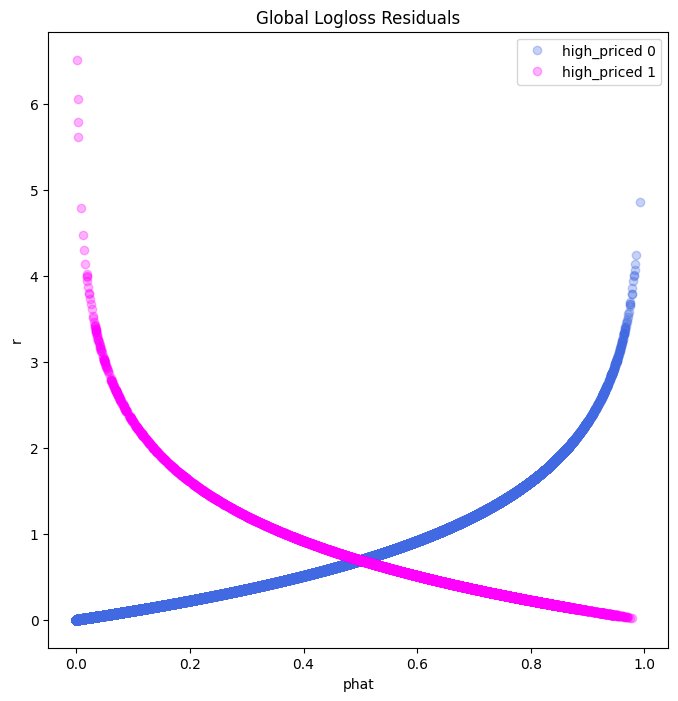

In [10]:
# initialize figure
fig, ax_ = plt.subplots(figsize=(8, 8))

# plot groups with appropriate color
color_list = ['royalblue', 'magenta']
c_idx = 0
groups = rem_ebm_phat.groupby(y_name) # define groups for levels of PAY_0
for name, group in groups:
    ax_.plot(group.phat, group.r,
             label=' '.join([y_name, str(name)]),
             marker='o', linestyle='', color=color_list[c_idx], alpha=0.3)
    c_idx += 1

# annotate plot
_ = plt.xlabel(yhat_name)
_ = plt.ylabel(r_name)
_ = ax_.legend(loc=1)
_ = plt.title('Global Logloss Residuals')

Residuals are very unbalanced. This model struggles to predict when customers will recieve a high-priced loan correctly. It does much better when predicting customers will NOT receive a high-priced loan. There are also some very noticable outliers.

## Remediation: Remove Outliers

#### Find outliers

In [11]:
rem_ebm_phat.sort_values(by='r', ascending=False).head()

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced,phat,r
71804,71804,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0.409027,0.171903,-4.091747,4.610857,0.204102,-0.018133,0.214735,1,0.001478,6.516914
31894,31894,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0.584916,-2.154007,0.244394,-0.215304,2.855893,0.068141,0.488963,1,0.002333,6.060521
110822,110822,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.892723,-0.874794,0.244394,-0.215304,1.252485,-0.007738,-1.156406,1,0.003054,5.791379
144991,144991,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,-0.382476,-1.782192,0.244394,-0.215304,0.389111,-0.052781,-1.156406,1,0.003642,5.615156
105145,105145,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,1.420391,-0.649142,-4.091747,2.197776,1.591667,-0.097823,1.585876,0,0.992228,4.857194


#### Remove worst outliers

In [12]:
n_remove = 10
rem_data = data.copy(deep=True)
rem_data.drop(list(rem_ebm_phat.sort_values(by='r', ascending=False).head(n=n_remove).index), axis=0, inplace=True)

## Remediation: Down-sample to Increase Signal from High-priced Loans

In [13]:
inverse_proportion_remove = 2 # corresponds to keeping 1 - (1/inverse_proportion_remove) rows
rem_data.drop(list(rem_data[rem_data[y_name] == 0].index)[::inverse_proportion_remove], axis=0, inplace=True)

#### Retrain remediated EBM

In [23]:
from sklearn.utils.class_weight import compute_sample_weight

np.random.seed(SEED) # preserve exact reproducibility for this cell

# execute split
split = np.random.rand(len(rem_data)) < split_ratio
rem_train = rem_data[split]
rem_valid = rem_data[~split]
# --- Residual Analysis: find outliers based on residuals ---
from sklearn.metrics import log_loss

# Predictions and residuals on training set
X_train = rem_train.drop(columns=[y_name])
y_train = rem_train[y_name]
y_pred_train = rem_ebm.predict_proba(X_train)[:, 1]
residuals = np.abs(y_train - y_pred_train)

# Threshold for extreme residuals (e.g., top 1%)
threshold = np.percentile(residuals, 99)
outlier_mask = residuals > threshold
print("Number of outliers to drop:", outlier_mask.sum())
# Drop those from train
X_train_clean = X_train[~outlier_mask]
y_train_clean = y_train[~outlier_mask]
# --- Handle imbalance via undersampling ---
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score

train_clean = pd.concat([X_train_clean, y_train_clean], axis=1)
majority = train_clean[train_clean[y_name] == 0]
minority = train_clean[train_clean[y_name] == 1]

majority_downsampled = resample(majority, replace=False, n_samples=len(minority), random_state=SEED)
train_balanced = pd.concat([majority_downsampled, minority])

X_final = train_balanced.drop(columns=[y_name])
y_final = train_balanced[y_name]


# summarize split
print('Remediated train data rows = %d, columns = %d' % (rem_train.shape[0], rem_train.shape[1]))
print('Remediated validation data rows = %d, columns = %d' % (rem_valid.shape[0], rem_valid.shape[1]))

# Compute weights for balanced learning
weights = compute_sample_weight(class_weight='balanced', y=train_balanced[y_name])

# retrain
rem_ebm2 = ExplainableBoostingClassifier(**rem_params)
# rem_ebm2.fit(rem_train[rem_x_names], rem_train[y_name])
# rem_ebm_perf2 = ROC(rem_ebm2.predict_proba).explain_perf(rem_valid[rem_x_names], rem_valid[y_name])
# rem_auc2 = rem_ebm_perf2._internal_obj['overall']['auc']
# print('Remediated EBM under-sampled AUC: %.4f.' % rem_auc2)
rem_ebm2.fit(X_final, y_final,sample_weight=weights)

/usr/local/lib/python3.11/dist-packages/interpret/utils/_clean_x.py:1260: UserWarning: Extra columns present in X that are not used by the model.
  warn("Extra columns present in X that are not used by the model.")


Number of outliers to drop: 615
Remediated train data rows = 61518, columns = 23
Remediated validation data rows = 26394, columns = 23


/usr/local/lib/python3.11/dist-packages/interpret/glassbox/_ebm/_ebm.py:812: UserWarning: Missing values detected. Our visualizations do not currently display missing values. To retain the glassbox nature of the model you need to either set the missing values to an extreme value like -1000 that will be visible on the graphs, or manually examine the missing value score in ebm.term_scores_[term_index][0]
  warn(


ExplainableBoostingClassifier(interactions=15, learning_rate=0.001,
                              max_bins=256, max_interaction_bins=32,
                              max_leaves=5, min_samples_leaf=1, n_jobs=4,
                              outer_bags=4, random_state=12345,
                              validation_size=0.1)

In [26]:
X_valid_rem = rem_valid.drop(columns=[y_name])
y_valid_rem = rem_valid[y_name]
y_pred_rem = rem_ebm2.predict_proba(X_valid_rem)[:, 1]
auc_rem = roc_auc_score(y_valid_rem, y_pred_rem)
print("Remediated EBM under-sampled and resampled AUC: %.4f" % auc_rem)

Remediated EBM under-sampled and resampled AUC: 0.8358


#### Test remediated EBM on true validation data

In [27]:
X_valid = valid.drop(columns=[y_name])
y_valid = valid[y_name]
y_pred_final = rem_ebm2.predict_proba(X_valid)[:, 1]
auc_final = roc_auc_score(y_valid, y_pred_final)
print("Validation AUC after remediation: %.4f" % auc_final)

Validation AUC after remediation: 0.8348


Dropping outliers and under-sampling increases true AUC!

In [ ]:
# # calculate predictions
# rem_ebm_phat2 = pd.DataFrame(rem_ebm.predict_proba(valid[rem_x_names])[:, 1], columns=['phat'])
# rem_ebm_phat2 = pd.concat([valid.reset_index(drop=True), rem_ebm_phat2], axis=1)
# rem_ebm_perf3 = ROC(rem_ebm2.predict_proba).explain_perf(valid[rem_x_names], valid[y_name])
# rem_auc3 = rem_ebm_perf3._internal_obj['overall']['auc']
# print('Remediated EBM true AUC: %.4f.' % rem_auc3)